## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.test.is_built_with_cuda()

True

In [3]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


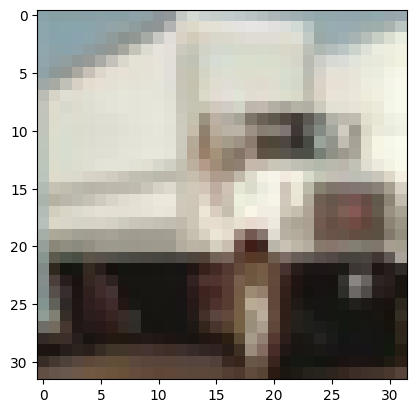

In [7]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])
plt.imshow(x_train[image_no]);

In [8]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [10]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [12]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               147968    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

We still have 181K parameters, even though this is a "small" model.


In [13]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.6789 - accuracy: 0.3902 - val_loss: 1.4864 - val_accuracy: 0.4739
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.3666 - accuracy: 0.5107 - val_loss: 1.2581 - val_accuracy: 0.5537
Epoch 3/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.2388 - accuracy: 0.5597 - val_loss: 1.1759 - val_accuracy: 0.5860
Epoch 4/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1561 - accuracy: 0.5905 - val_loss: 1.1731 - val_accuracy: 0.5829
Epoch 5/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.0982 - accuracy: 0.6161 - val_loss: 1.1244 - val_accuracy: 0.6089
Epoch 6/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.0562 - accuracy: 0.6313 - val_loss: 1.0878 - val_accuracy: 0.6206
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0257 - accuracy: 0.6408 - val_loss: 1.1070 -

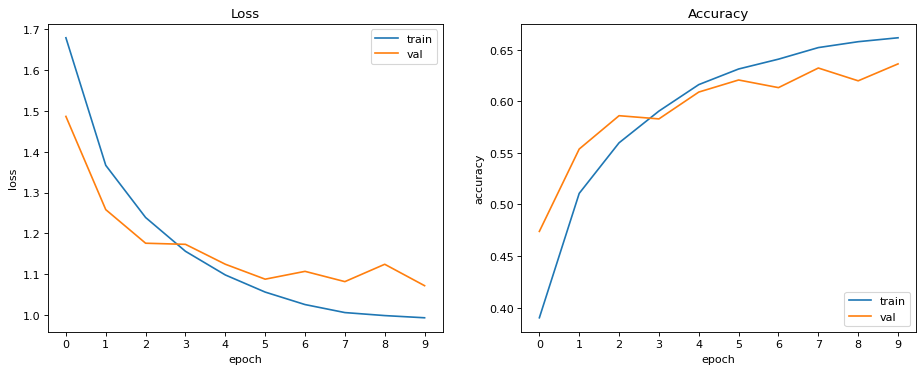

In [14]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

### Model Evaluation

In [15]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.921138, Accuracy: 0.690400
 Test Loss: 1.071888, Accuracy: 0.636200

[[702  28  82  25  41  16  10  28  85  31]
 [ 17 725  13  13   1   8   4   6  48  99]
 [ 36   4 430  50  53  50  28  31   8   4]
 [ 16  11  61 442  44 211  36  43  18  19]
 [ 24   4 131 115 628 108  31 139   7   5]
 [  6   2  44 102  17 406   8  50   4   9]
 [ 21  24 162 166 128 117 854  24   8  18]
 [ 14   4  36  37  59  51  10 644   7  24]
 [104  22  19  17  20  16   5   7 766  26]
 [ 60 176  22  33   9  17  14  28  49 765]]


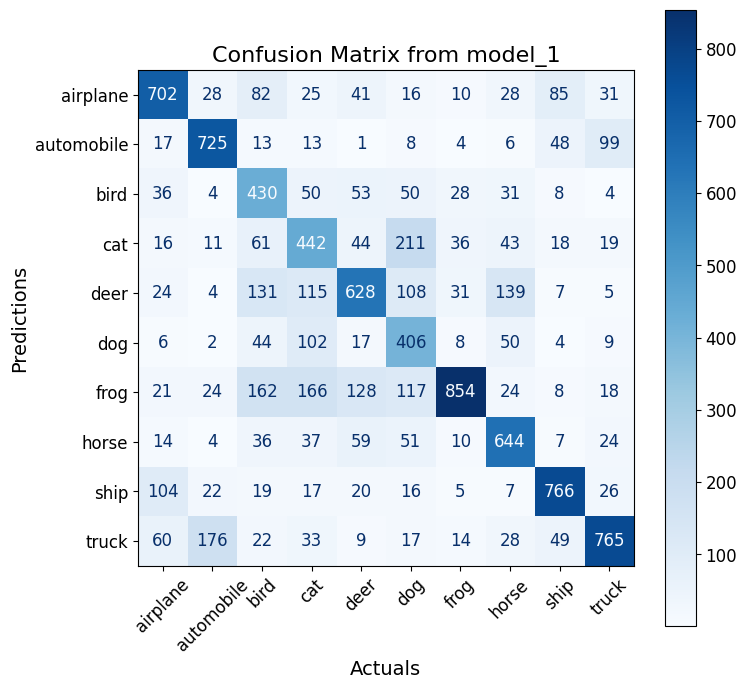

In [16]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [17]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.67      0.70      0.69      1000
  automobile       0.78      0.72      0.75      1000
        bird       0.62      0.43      0.51      1000
         cat       0.49      0.44      0.47      1000
        deer       0.53      0.63      0.57      1000
         dog       0.63      0.41      0.49      1000
        frog       0.56      0.85      0.68      1000
       horse       0.73      0.64      0.68      1000
        ship       0.76      0.77      0.77      1000
       truck       0.65      0.77      0.70      1000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.63     10000
weighted avg       0.64      0.64      0.63     10000



$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$

where 
$TP$: True Positives, $TN$: True Negatives, $FP$: False Positives, and $FN$: False Negatives


### <span style="color:blue">แบบฝึกปฏิบัติ</span>
จากโครงสร้างของโมเดลเดิม:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:
   - Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

   - ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

2. เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

3. จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report

4. หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

### <span style="color:pink">จากแบบฝึกปฏิบัติ</span>

In [11]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                    

In [19]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 186s 117ms/step - loss: 1.6013 - accuracy: 0.4181 - val_loss: 1.3120 - val_accuracy: 0.5333
Epoch 2/10
1563/1563 [==============================] - 174s 112ms/step - loss: 1.1722 - accuracy: 0.5837 - val_loss: 1.0486 - val_accuracy: 0.6290
Epoch 3/10
1563/1563 [==============================] - 183s 117ms/step - loss: 0.9820 - accuracy: 0.6561 - val_loss: 0.9314 - val_accuracy: 0.6758
Epoch 4/10
1563/1563 [==============================] - 187s 119ms/step - loss: 0.8712 - accuracy: 0.6989 - val_loss: 0.9119 - val_accuracy: 0.6857
Epoch 5/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.8093 - accuracy: 0.7215 - val_loss: 0.9352 - val_accuracy: 0.6961
Epoch 6/10
1563/1563 [==============================] - 162s 103ms/step - loss: 0.7635 - accuracy: 0.7391 - val_loss: 0.8358 - val_accuracy: 0.7200
Epoch 7/10
1563/1563 [==============================] - 138s 88ms/step - loss: 0.7290 - accuracy: 0.7548 - val_l

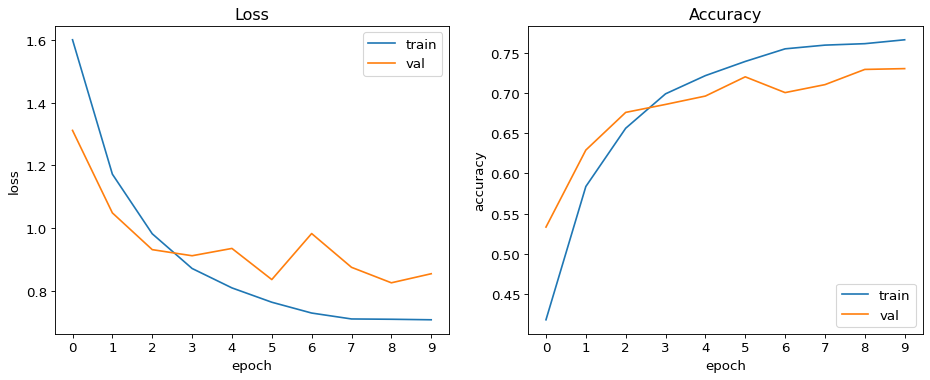

In [20]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [21]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.573642, Accuracy: 0.801040
 Test Loss: 0.854460, Accuracy: 0.730200

[[791  15  87  24  17  13  10  13 107  29]
 [ 10 816   4   6   1   1   3   2  26  40]
 [ 32   4 464  29  18  17  21   6   8   3]
 [ 35  13 110 666  81 252 101  54  27  21]
 [ 29   7 126  57 729  47  39  75   5   6]
 [  4   1  73 105  26 589   8  33   3   3]
 [  9   6  67  49  48  19 796   5   4   5]
 [ 16   3  48  34  69  54   9 795   2  12]
 [ 36  21   8  15   8   3   8   3 793  18]
 [ 38 114  13  15   3   5   5  14  25 863]]


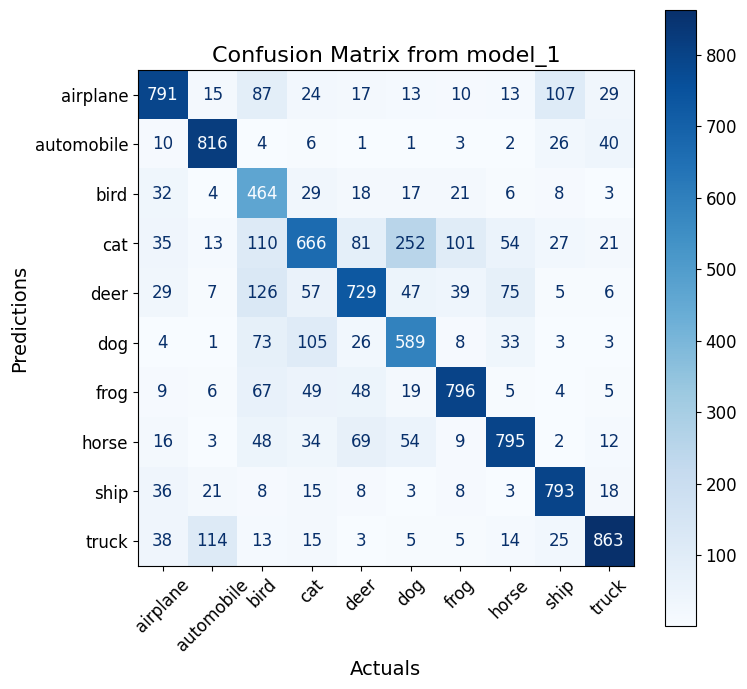

In [22]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

## GPU Test

In [12]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10


: 